In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
from tqdm import tqdm
import warnings
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
import scipy.stats as stats
from glob import glob
## my own directory
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")


In [2]:
from gstools import CovModel
import gstools as gs

class Stab(CovModel):
    def variogram(self, r):
        
        return self.nugget + self.sill * (1 - np.exp(-(3 * r) / self.len_scale))

In [3]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [4]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

def get_year(date):
    year = date.year
    return year

In [5]:
def calc_ratio_gamma(N11,N10):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        ratio = np.where(N10 + N11 != 0, 0.5 * (N10 / (N10 + N11)), np.nan)
    return ratio

# Method: weighted bins

begin preprocessing

In [6]:
def range_from_sill(model, r_bins, percent=0.95):
    sill = 0.5 #model.nugget+model.sill
    yfit = model.variogram(r_bins)
    if len(np.argwhere(yfit<sill*percent)) > 0:
        cut = sill*percent
        prange = np.interp(cut, yfit, r_bins)
    else:
        prange = r_bins[0]
    return prange

def range_from_gamma(model, r_bins,gamma,percent=0.9):
    yfit = model.variogram(r_bins)
    if len(np.argwhere(yfit<np.nanmax(gamma)*percent)) > 0:
        cut = np.nanmax(gamma)*percent
        prange = np.interp(cut, yfit, r_bins)
    else:
        prange = r_bins[0]
    return prange

In [7]:
bin_files = sorted(glob("./data/all_AU_p90_500km/*_pair_bins_moving_list_all_events.csv"))
#"./data/all_AU_p90_500km/*_pair_bins_moving_list_all_events.csv" /scratch/k10/dl6968/all_AU_p90_qc/
fit_model = gs.Spherical(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)
r_bins =  np.arange(1,520,25) #np.arange(1,370,20)#   np.arange(1,1520,25) #  
rmax = 501# 361#501
# Function to compute weighted mean of gamma for each bin
def weighted_mean(x,field="gamma"):
    if np.sum(x["Norm_Weight"]) > 0:
        return np.sum(x[field] * x["Norm_Weight"]) / np.sum(x["Norm_Weight"])
    else: 
        return 0

def bins_to_season(file):
    bins_yfit_dict = {}
    bins_scale_dict = {}
    event_num_dict = {}
    df_bins = pd.read_csv(file, usecols=lambda col: not col.startswith("Unnamed"))
    # these are where the station number filter has been applied, I used y_fit for simplicity
    df_bins = df_bins[ (df_bins["y_fit"]>0) & (df_bins["Bins"]<=rmax)] 
    if len(df_bins)==0:
        for seasons in ["DJF", "MAM", "JJA", "SON"]:
            bins = r_bins
            y_fit = np.zeros_like(bins)
            gamma = np.zeros_like(bins)
            scale = np.nan
            bins_yfit_dict[seasons+"_yfit"] = y_fit
            bins_yfit_dict[seasons+"_gamma"] = gamma    
            bins_scale_dict[seasons] = scale
    else:
        df_bins["Date"] = pd.to_datetime(df_bins["Date"])
        df_bins["Season"] = df_bins["Date"].apply(get_season)
        df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
        mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
        df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
        ## normalise weight
        df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
        
        # Apply the weighted mean function per Season & Bin
        ivw_gamma = df_bins.groupby(["Season", "Bins"]).apply(lambda x: weighted_mean(x, field="gamma"), include_groups=False
                                                           ).reset_index(name="IVW_Gamma")
        # bins_yfit_dict = {}
        # bins_scale_dict = {}
        for seasons in ["DJF", "MAM", "JJA", "SON"]:
            bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
            gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
            event_num_dict[seasons] = len(np.unique(df_bins[df_bins["Season"]==seasons]["Date"]))

            ## if have less than 10 events per season, this should not be considered
            if len(gamma)==0:# or len(df_bins[df_bins["Season"]==seasons])/r_bins.shape[0]<10:
                bins = r_bins
                y_fit = np.zeros_like(bins)
                gamma = np.zeros_like(bins)
                scale = np.nan
                
            else:
                try:
                    gamma_fit = gamma[gamma>0]
                    bins_fit = bins[gamma>0]
                    _ = fit_model.fit_variogram(bins_fit, gamma_fit)#, sill=0.5-0.025, nugget=0.025)
                    y_fit = fit_model.variogram(bins)
                    # if fit_model.sill + fit_model.nugget<=0.5:
                    scale = fit_model.len_scale
                    # else:
                    #     scale = range_from_gamma(fit_model, bins,gamma,0.95)
                except RuntimeError:
                    # try:
                    #     gamma_fit = gamma[gamma>0]
                    #     bins_fit = bins[gamma>0]
                    #     _ = fit_model.fit_variogram(bins_fit, gamma_fit,init_guess={"nugget":0})#, sill=0.5-0.025, nugget=0.025)
                    #     y_fit = fit_model.variogram(bins)
                    #     scale = fit_model.len_scale
                    # except RuntimeError:
                        scale = fit_model.len_scale
                        y_fit = np.zeros_like(bins)
                        scale = np.nan
            bins_yfit_dict[seasons+"_yfit"] = y_fit
            bins_yfit_dict[seasons+"_gamma"] = gamma    
            bins_scale_dict[seasons] = scale
            bins_yfit_dict["Bins"] = bins
        df_season_bins = pd.DataFrame.from_dict(bins_yfit_dict)
        df_season_bins.to_csv(file.replace("pair", "season"))
        df_season_scale = pd.DataFrame.from_dict(bins_scale_dict, orient="index", columns=["scale"])
        df_season_scale.to_csv(file.replace("pair_bins", "season_scale"))
        df_event_num = pd.DataFrame.from_dict(event_num_dict, orient="index", columns=["event_num"])
        df_event_num.to_csv(file.replace("pair_bins", "event_num"))

### testing

In [46]:
file = bin_files[127]#"/scratch/k10/dl6968/all_AU_p90_qc/37107_pair_bins_moving_list_all_events.csv"
# stn_file = "./data/all_AU_p90_500km/29052_station_moving_list_all_events.csv"
fit_model = gs.Spherical(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)

bins_yfit_dict = {}
bins_scale_dict = {}
event_num_dict = {}
# df_stn = pd.read_csv(stn_file, index_col=0)
df_bins = pd.read_csv(file, usecols=lambda col: not col.startswith("Unnamed"))
df_bins = df_bins[(df_bins["y_fit"]>0) & (df_bins["Bins"]<=501)]
if len(df_bins)==0:
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        bins = np.arange(1,1520,25)
        y_fit = np.zeros_like(bins)
        gamma = np.zeros_like(bins)
        scale = np.nan
        bins_yfit_dict[seasons+"_yfit"] = y_fit
        bins_yfit_dict[seasons+"_gamma"] = gamma    
        bins_scale_dict[seasons] = scale
else:
    df_bins["Date"] = pd.to_datetime(df_bins["Date"])
    df_bins["Season"] = df_bins["Date"].apply(get_season)
    df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
    mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
    df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
    ## normalise weight
    df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
    
    # Apply the weighted mean function per Season & Bin
    ivw_gamma = df_bins.groupby(["Season", "Bins"]).apply(lambda x: weighted_mean(x, field="gamma"), include_groups=False
                                                       ).reset_index(name="IVW_Gamma")
    # bins_yfit_dict = {}
    # bins_scale_dict = {}
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
        gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
        event_num_dict[seasons] = len(np.unique(df_bins[df_bins["Season"]==seasons]["Date"]))
        if len(gamma)==0:
            bins = r_bins# np.arange(1,1520,25)
            y_fit = np.zeros_like(bins)
            gamma = np.zeros_like(bins)
            scale = np.nan
            
        else:
            try:
                gamma_fit = gamma[gamma>0]
                bins_fit = bins[gamma>0]
                _ = fit_model.fit_variogram(bins_fit, gamma_fit)#, sill=0.5-0.025, nugget=0.025)
                y_fit = fit_model.variogram(bins)
                # if fit_model.sill + fit_model.nugget<=0.5:
                scale = fit_model.len_scale
                # else:
                #     scale = range_from_gamma(fit_model, bins,gamma,0.95)
            except RuntimeError:
                try:
                    gamma_fit = gamma[gamma>0]
                    bins_fit = bins[gamma>0]
                    _ = fit_model.fit_variogram(bins_fit, gamma_fit,init_guess={"nugget":0})#, sill=0.5-0.025, nugget=0.025)
                    y_fit = fit_model.variogram(bins)
                except RuntimeError:
                    scale = fit_model.len_scale
                    y_fit = np.zeros_like(bins)
                    scale = np.nan
        bins_yfit_dict[seasons+"_yfit"] = y_fit
        bins_yfit_dict[seasons+"_gamma"] = gamma    
        bins_scale_dict[seasons] = scale
        bins_yfit_dict["Bins"] = bins
    df_season_bins = pd.DataFrame.from_dict(bins_yfit_dict)
    df_season_bins.to_csv(file.replace("pair", "season"))
    df_season_scale = pd.DataFrame.from_dict(bins_scale_dict, orient="index", columns=["scale"])
    df_season_scale.to_csv(file.replace("pair_bins", "season_scale"))
    df_event_num = pd.DataFrame.from_dict(event_num_dict, orient="index", columns=["event_num"])
    df_event_num.to_csv(file.replace("pair_bins", "event_num"))

In [13]:
bins_scale_dict
# gamma_fit[N11+N10<=2] = np.nan
#     bins_fit[N11+N10<=2] = np.nan
    
#     ## remove NaNs 
#     gamma_fit1 = gamma_fit[~np.isnan(gamma_fit)]
#     bins_fit1 = bins_fit[~np.isnan(bins_fit)]

{'DJF': 357.28799370084187,
 'MAM': 367.5273722576508,
 'JJA': 458.28989062408056,
 'SON': 329.4186419067232}

In [14]:
for seasons in ["DJF", "MAM", "JJA", "SON"]:
    gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
    bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
    gamma_fit = gamma[gamma>0]
    bins_fit = bins[gamma>0]
    fit_model = gs.Gaussian(dim=2)
    _ = fit_model.fit_variogram(bins_fit, gamma_fit)#, sill=0.5-0.025, nugget=0.025)
    y_fit = fit_model.variogram(bins)
    scale = range_from_sill(fit_model, bins,0.950)
    print(seasons, scale, fit_model.len_scale)

DJF 501.0 136.72110505708457
MAM 501.0 147.64028612785447
JJA 501.0 184.1446712383714
SON 501.0 123.46361493340639


In [15]:
fit_model = gs.Spherical(dim=2)
exp_model = Stab(dim=2)

In [16]:
seasons="MAM"
gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
_ = fit_model.fit_variogram(bins[gamma>0], gamma[gamma>0], init_guess={"nugget":0.0})#, sill=0.5-0.025, nugget=0.025)
y_fit = fit_model.variogram(bins)
scale = fit_model.len_scale

_ = exp_model.fit_variogram(bins[gamma>0], gamma[gamma>0])#, sill=0.5-0.025, nugget=0.025)
y_fit_exp = exp_model.variogram(bins)
scale_exp = exp_model.len_scale

print(fit_model.len_scale, exp_model.len_scale)

367.52851991833194 2830.3162331555845


(0.0, 0.5)

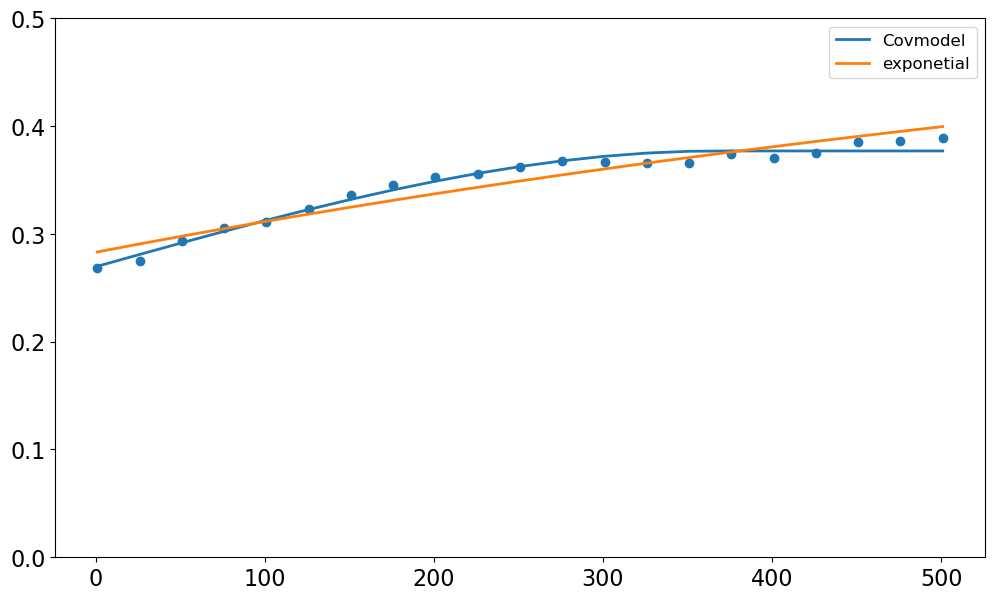

In [17]:
plt.scatter(bins,gamma)
# plt.scatter(bins_long, gamma_long)
plt.plot(bins,y_fit, label="Covmodel")
plt.plot(bins,y_fit_exp, label="exponetial")
# plt.axhline(y=np.nanmax(gamma)*0.95,color="r", label="0.5*95%")
plt.legend()
plt.ylim([0,0.5])

## Main parallel run

In [8]:
max_pool = 28
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(bins_to_season,
                   bin_files),
        total=len(bin_files),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()


Processing seasonality: 100%|██████████| 9847/9847 [01:54<00:00, 86.07it/s] 


In [9]:
df = pd.read_csv("./data/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6) # ./data/all_AU_p90_500km/ /scratch/k10/dl6968/all_AU_p90_qc/
    if not os.path.exists(f'./data/all_AU_p90_500km/{stn_id}_season_scale_moving_list_all_events.csv'):
        exclude_stn.append(stn_id)
## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]
df.to_csv("./data/BoM_daily_stations_500km.csv")

End of preprocessing

In [6]:
df= pd.read_csv("./data/BoM_daily_stations_500km.csv")

In [7]:
season_weight_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):#/scratch/k10/dl6968/all_AU_p90_qc ./data/all_AU_p90_500km/
    df_scale = pd.read_csv(f"./data/all_AU_p90_500km/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_weight_dict[seasons].append( df_scale.loc[seasons].values[0])

100%|██████████| 9835/9835 [06:30<00:00, 25.19it/s]


In [8]:
season_num_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):#/scratch/k10/dl6968/all_AU_p90_qc ./data/all_AU_p90_500km/
    df_scale = pd.read_csv(f"./data/all_AU_p90_500km/{spec_id}_event_num_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_num_dict[seasons].append( df_scale.loc[seasons].values[0])

100%|██████████| 9835/9835 [05:53<00:00, 27.78it/s]


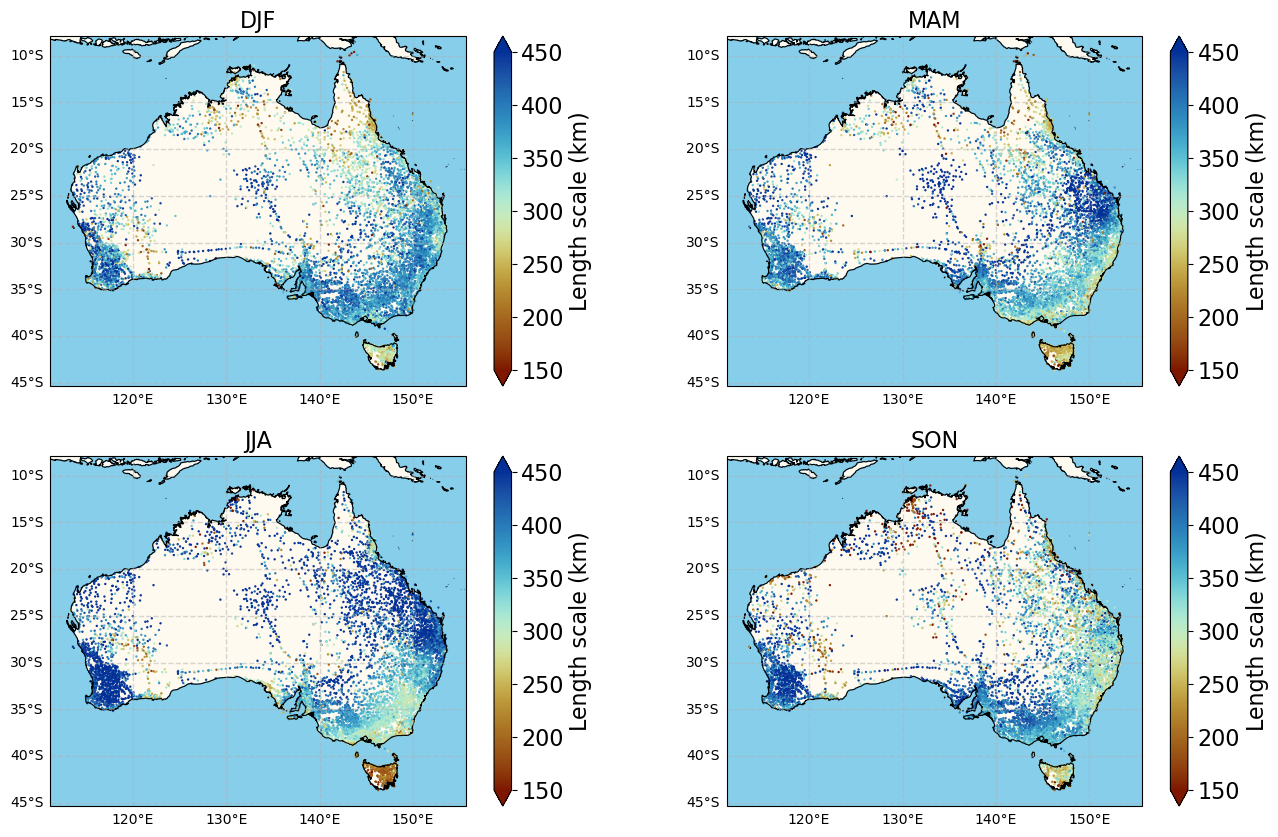

In [13]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = "cmc.roma"
vmin=150
vmax=450
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["DJF"], cmap=cmap, vmin=vmin,vmax=vmax, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["MAM"], cmap=cmap, vmin=vmin,vmax=vmax,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["JJA"], cmap=cmap, vmin=vmin,vmax=vmax, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["SON"],  cmap=cmap, vmin=vmin,vmax=vmax,   
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
# plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")

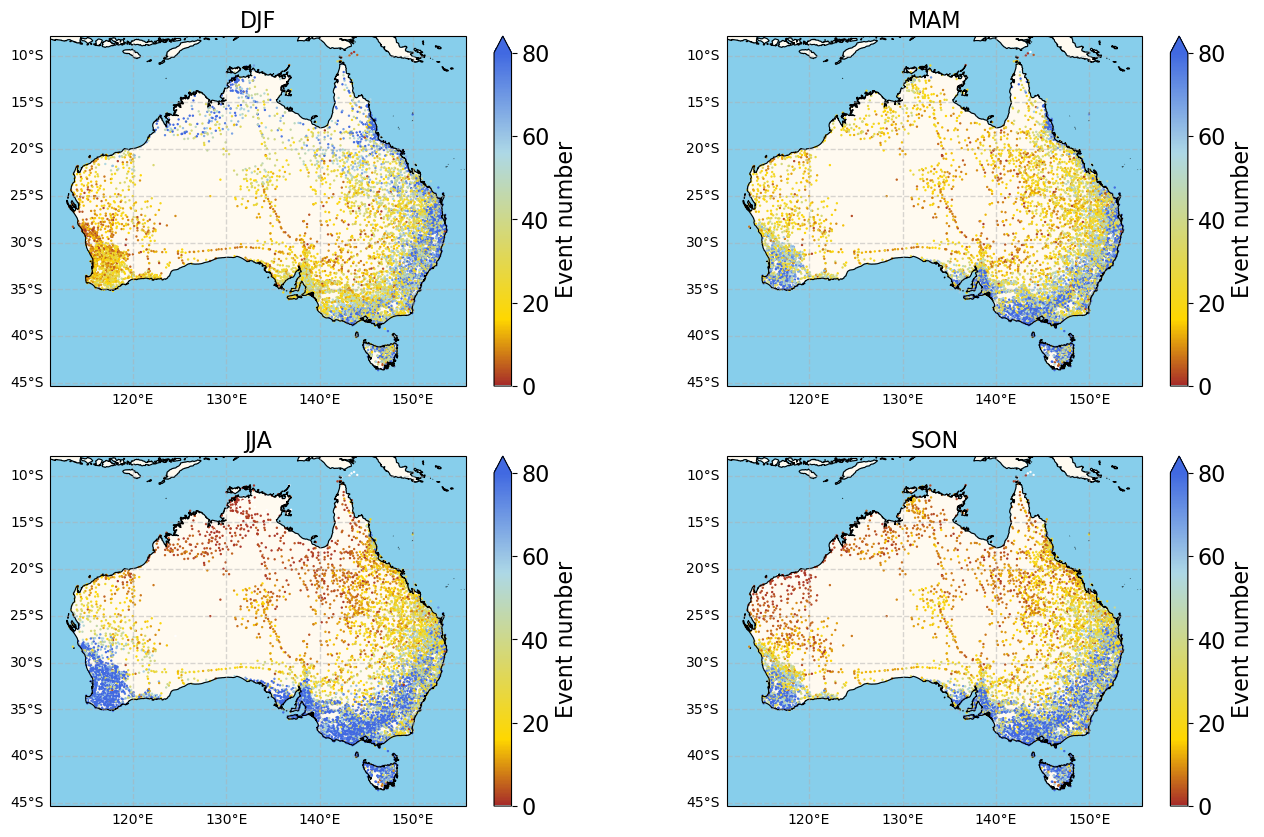

In [14]:
fig = plt.figure(figsize=(16,10))
# Define color segments
colors = [
    (0, "brown"),    
    (0.2, "gold"), 
    (0.7, "lightblue"),
    (1, "royalblue")      
]
# colors[0] = [1, 1, 1, 1]

# Create custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

new_colors = custom_cmap(np.linspace(0, 1, 256))  # Extract the colormap's colors
new_colors[0] = [1, 1, 1, 1]  # Set the first color (corresponding to zero) to white
new_cmap = LinearSegmentedColormap.from_list("Custom_cmap", new_colors)
cmap = new_cmap
vmin=0
vmax=80
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1, projection=ccrs.PlateCarree())
    
    
    plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_num_dict[seasons], cmap=cmap, vmin=vmin,vmax=vmax, 
                transform=ccrs.PlateCarree())
    cbar = plt.colorbar(extend="max")
    cbar.ax.set_ylabel("Event number")
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax1.set_title(seasons)
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='skyblue')  

In [87]:
df_500km = pd.read_csv("./data/BoM_daily_stations_500km.csv")
df_both = df[df["ID"].isin(df_500km["ID"])].reset_index()

In [88]:
season_350km_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
season_500km_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}

for spec_id in tqdm(df_both["ID"],leave=True, position=0):
    df_scale_350 = pd.read_csv(f"/scratch/k10/dl6968/all_AU_p90_qc/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    df_scale_500 = pd.read_csv(f"./data/all_AU_p90_500km/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_350km_dict[seasons].append( df_scale_350.loc[seasons].values[0])
        season_500km_dict[seasons].append( df_scale_500.loc[seasons].values[0])

100%|██████████| 9831/9831 [07:29<00:00, 21.85it/s] 


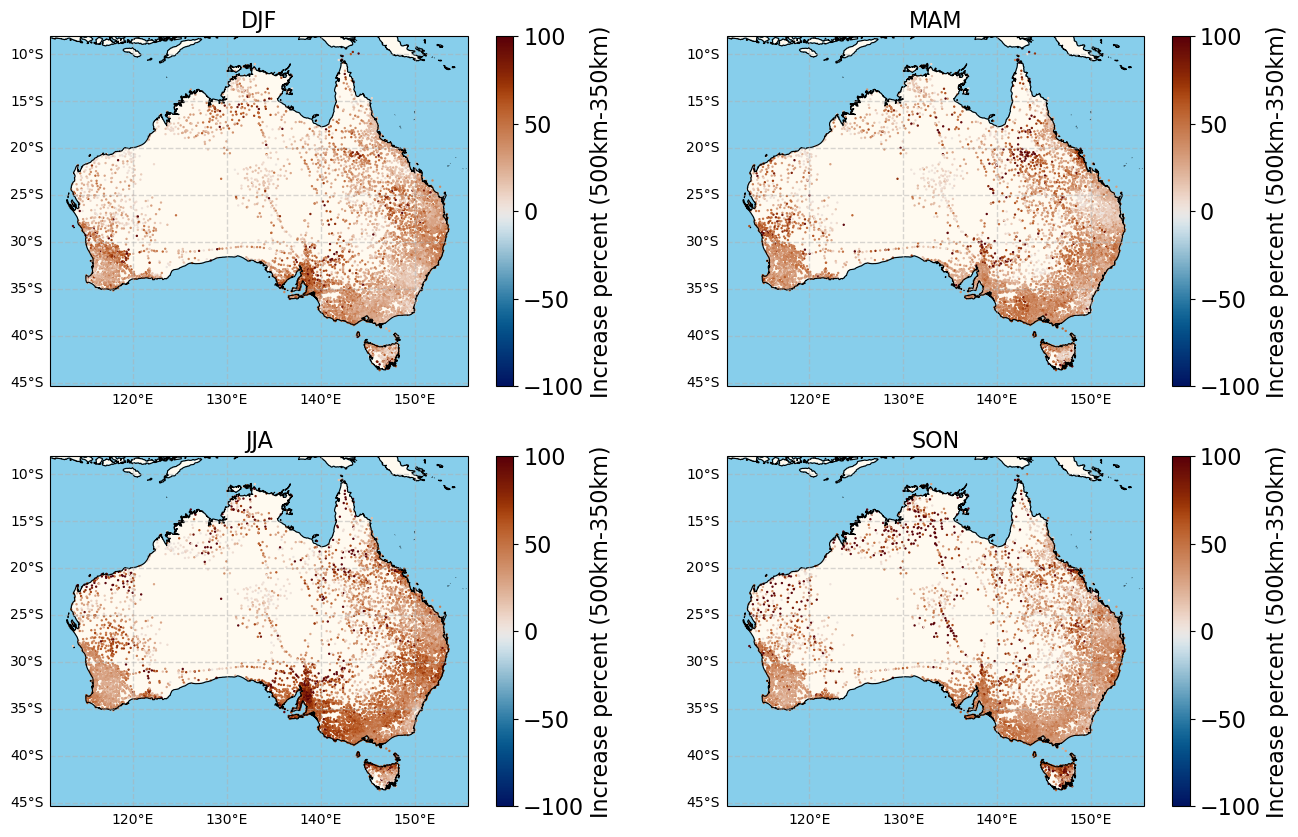

In [89]:
fig = plt.figure(figsize=(16,10))
cmap = "cmc.vik"
vmin=-100
vmax=100
for i, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax1 = fig.add_subplot(2,2,i+1, projection=ccrs.PlateCarree())
    
    season_percent = np.abs(np.array(season_500km_dict[seasons])-np.array(season_350km_dict[seasons])) / ((np.array(season_500km_dict[seasons])+np.array(season_350km_dict[seasons])) / 2) * 100

    plt.scatter(df_both["Longitude"], df_both["Latitude"], s=0.5, c= season_percent, cmap=cmap, vmin=vmin,vmax=vmax, 
                transform=ccrs.PlateCarree())
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Increase percent (500km-350km)")
    ax1.coastlines('10m', color="black",linewidth=0.8)
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                     linewidth=1, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax1.set_title(seasons)
    ax1.add_feature(cfeature.LAND, color='floralwhite')  
    ax1.add_feature(cfeature.OCEAN, color='skyblue')  



# NRM regions

In [9]:
# Load the shapefile of regions
regions_gdf = gpd.read_file("/g/data/k10/dl6968/Rain_gauge_scale/data/NRM_modified/NRM_modified.shp") 

In [10]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
stations_with_regions = gpd.sjoin(stations_gdf, regions_gdf, how="left", predicate="within")

WT_stn = stations_with_regions[stations_with_regions["code"]=="WT"]
SFW_stn = stations_with_regions[stations_with_regions["code"]=="SSWFW"]
SFE_stn = stations_with_regions[stations_with_regions["code"]=="SSWFE"]
VICW_stn = stations_with_regions[stations_with_regions["code"]=="SSVW"]
VICE_stn = stations_with_regions[stations_with_regions["code"]=="SSVE"]
TASW_stn = stations_with_regions[stations_with_regions["code"]=="SSTW"]
TASE_stn = stations_with_regions[stations_with_regions["code"]=="SSTE"]
RW_stn = stations_with_regions[stations_with_regions["code"]=="RW"]
RE_stn = stations_with_regions[stations_with_regions["code"]=="RE"]
MNW_stn = stations_with_regions[stations_with_regions["code"]=="MNW"]
MNE_stn = stations_with_regions[stations_with_regions["code"]=="MNE"]
MB_stn = stations_with_regions[stations_with_regions["code"]=="MB"]
ECS_stn = stations_with_regions[stations_with_regions["code"]=="ECS"]
ECN_stn = stations_with_regions[stations_with_regions["code"]=="ECN"]
CS_stn = stations_with_regions[stations_with_regions["code"]=="CS"]

In [11]:
def nrm_season_weighted(id_df):
    djf_scale = np.array([df_season_weight[df_season_weight["ID"]==spec_id]["DJF"].values[0] for spec_id in id_df])
    mam_scale = np.array([df_season_weight[df_season_weight["ID"]==spec_id]["MAM"].values[0] for spec_id in id_df])
    jja_scale = np.array([df_season_weight[df_season_weight["ID"]==spec_id]["JJA"].values[0] for spec_id in id_df])
    son_scale = np.array([df_season_weight[df_season_weight["ID"]==spec_id]["SON"].values[0] for spec_id in id_df])
    
    djf_valid = djf_scale#[~np.isnan(djf_scale)]
    mam_valid = mam_scale#[~np.isnan(mam_scale)]
    jja_valid = jja_scale#[~np.isnan(jja_scale)]
    son_valid = son_scale#[~np.isnan(son_scale)]
    
    # djf_valid[djf_valid>1500] = 1500
    # mam_valid[mam_valid>1500] = 1500
    # jja_valid[jja_valid>1500] = 1500
    # son_valid[son_valid>1500] = 1500
    return [djf_valid, mam_valid, jja_valid, son_valid]

In [12]:
season_weight_dict["ID"] = df["ID"].values
df_season_weight = pd.DataFrame.from_dict(season_weight_dict)
nrm_sub_wscale_dict = {}
for regions in stations_with_regions["code"].unique()[:-1]:
    nrm_sub_wscale_dict[regions] = nrm_season_weighted(stations_with_regions[stations_with_regions["code"]==regions]["ID"])

In [13]:
## change the keys so I can remember them easily
for nrm_dicts in [nrm_sub_wscale_dict]:
    nrm_dicts["SFW"] = nrm_dicts.pop("SSWFW")
    nrm_dicts["SFE"] = nrm_dicts.pop("SSWFE")
    nrm_dicts["VICW"] = nrm_dicts.pop("SSVW")
    nrm_dicts["VICE"] = nrm_dicts.pop("SSVE")
    nrm_dicts["TASW"] = nrm_dicts.pop("SSTW")
    nrm_dicts["TASE"] = nrm_dicts.pop("SSTE")

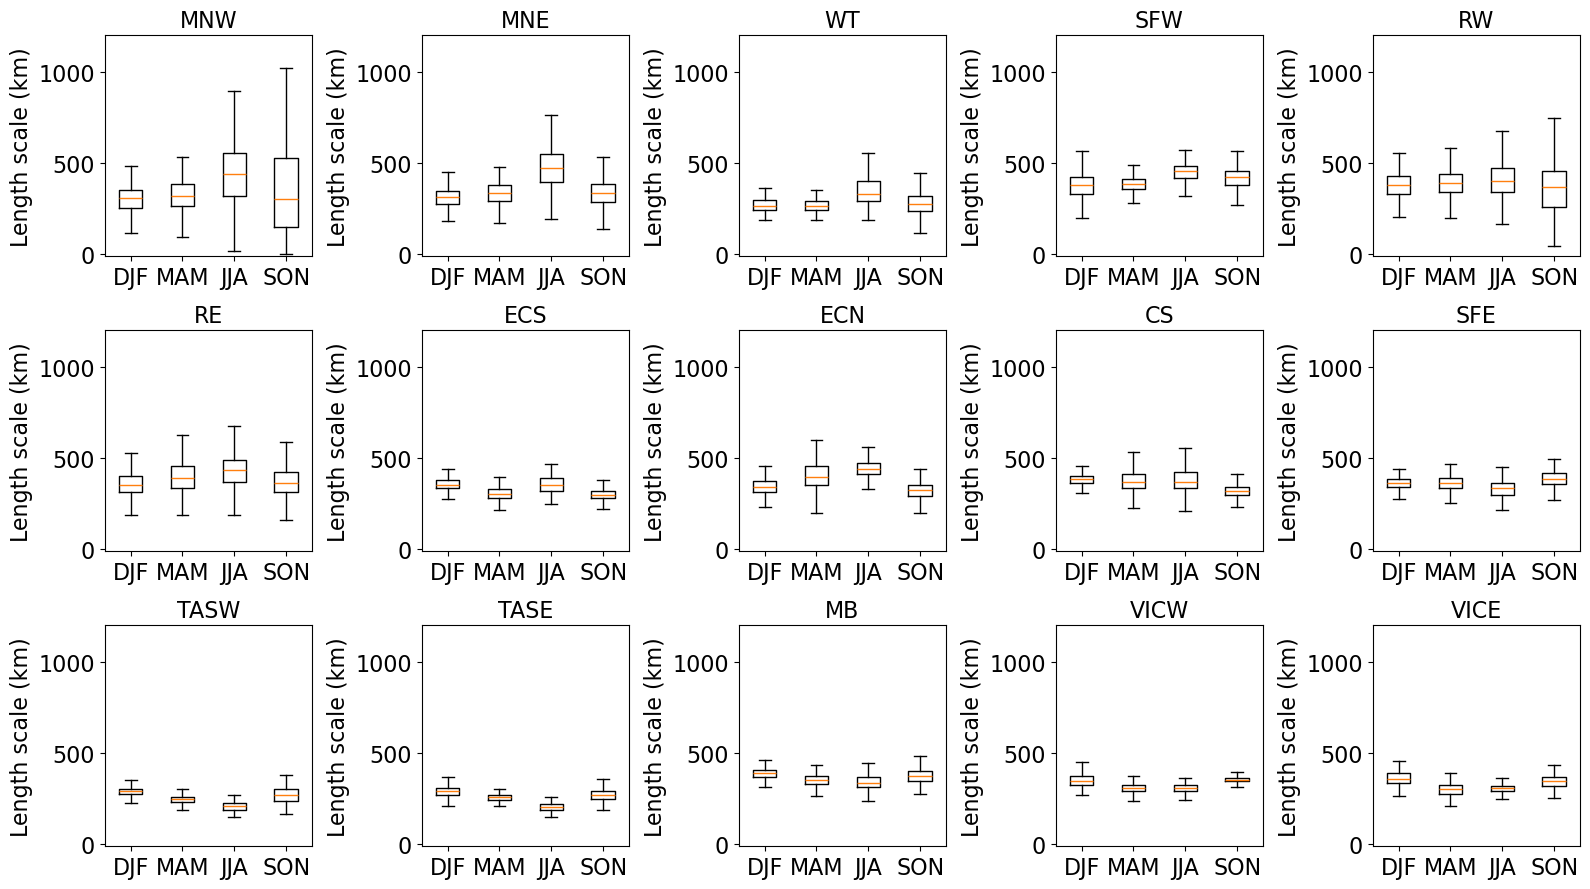

In [20]:
plt.figure(figsize=(16,9))
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    plt.subplot(3,5,i+1)
    data_list = [data[~np.isnan(data)] for data in nrm_sub_wscale_dict[region]]
    _ = plt.boxplot(data_list, showfliers=False)
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
    plt.ylabel("Length scale (km)")
    plt.title(region)
    plt.ylim([-10,1200])
plt.tight_layout()

# Heatmap

In [14]:
import seaborn as sns
import scipy.stats as stats
from matplotlib.lines import Line2D


In [15]:
region_list = ["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]

In [16]:
mann_dict = {}

for iregion in region_list:
    mann_dict[iregion] = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
    for jregion in region_list:
        for iseason, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
            pvalue = stats.mannwhitneyu(nrm_sub_wscale_dict[iregion][iseason][~np.isnan(nrm_sub_wscale_dict[iregion][iseason])],
                                        nrm_sub_wscale_dict[jregion][iseason][~np.isnan(nrm_sub_wscale_dict[jregion][iseason])])[1]
            mann_dict[iregion][seasons].append(pvalue)

In [17]:
pvalue_djf = np.array([np.array(mann_dict[region]["DJF"]) for region in region_list])
pvalue_mam = np.array([np.array(mann_dict[region]["MAM"]) for region in region_list])
pvalue_jja = np.array([np.array(mann_dict[region]["JJA"]) for region in region_list])
pvalue_son = np.array([np.array(mann_dict[region]["SON"]) for region in region_list])
pvalue_matrix = [pvalue_djf, pvalue_mam, pvalue_jja, pvalue_son]

/jobfs/138666501.gadi-pbs/ipykernel_2523407/602925425.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout so the colorbar doesn't overlap


<Figure size 1200x700 with 0 Axes>

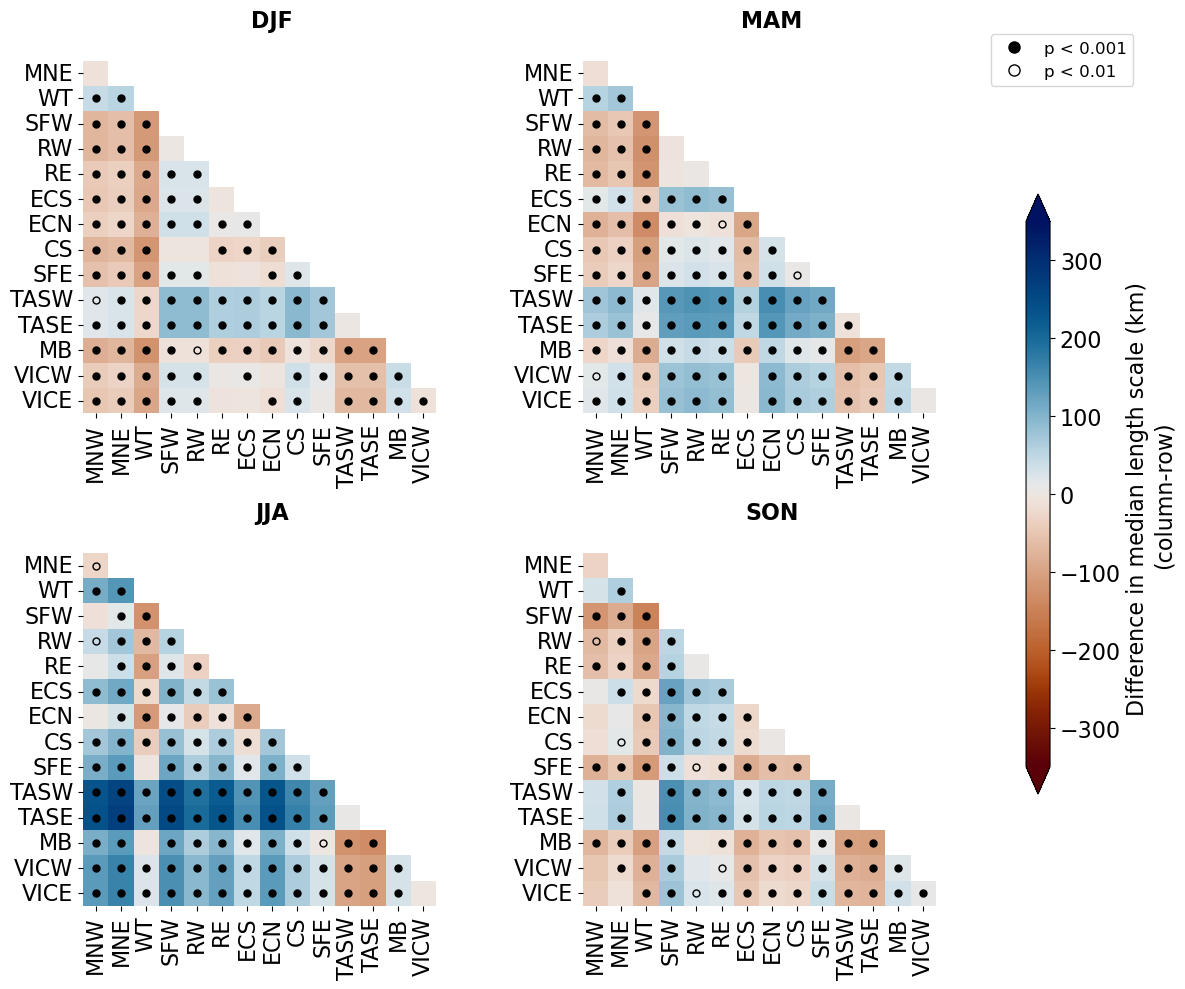

In [21]:
plt.figure()
# Sample figure and axes
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
axes = [ax1, ax2, ax3, ax4]

# Loop over seasons and subplots
for iseason, season, ax in zip(range(4), ["DJF", "MAM", "JJA", "SON"], axes):

    # Generate your data (using region_list from your context)
    diff= np.array([np.nanmedian(nrm_sub_wscale_dict[region][iseason])
                           for region in region_list])
    diff_matrix= diff[None, :] - diff[:, None]

    # Create an upper-triangular mask if needed
    mask = np.zeros_like(diff_matrix)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        # Disable the colorbar for each heatmap (cbar=False)
        g1 = sns.heatmap(diff_matrix, mask=mask, square=True,
                         vmin=-350, vmax=350, cmap="cmc.vik_r", cbar=False, ax=ax)
        # Set the tick positions and labels; ensure the number matches region_list length
        n_regions = len(region_list)-1
        ax.set_xticks(np.arange(n_regions) + 0.5)
        ax.set_xticklabels(region_list[:-1], rotation=90)
        ax.set_yticks(np.arange(n_regions) + 1.5)
        ax.set_yticklabels(region_list[1:], rotation=0)
        ax.set_title(season,fontweight="bold")
# Overlay markers based on p-value thresholds.
    # Iterate over each cell in the p-value matrix.
    for i in range(pvalue_matrix[iseason].shape[0]):
        for j in range(pvalue_matrix[iseason].shape[1]):
            p = pvalue_matrix[iseason][i, j]
            if p < 0.001 and mask[i,j]==False:
                # Solid black dot
                markerfacecolor = "black"
                markeredgecolor = "black"
            elif p < 0.01 and mask[i,j]==False:
                # Hollow dot (no face color, just edge)
                markerfacecolor = "none"
                markeredgecolor = "black"
            else:
                continue  # Do nothing if p-value doesn't meet criteria.
            # Plot the marker at the center of cell (i, j)
            ax.plot(j + 0.5, i + 0.5, marker='o', markersize=5,
                    markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
    plt.tight_layout() 
# Create a single colorbar for the entire figure.
# Define the position of the colorbar axis: [left, bottom, width, height]
cbar_ax = f.add_axes([0.92, 0.2, 0.02, 0.6])
# Create a ScalarMappable with the same colormap and normalization as the heatmaps
norm = plt.Normalize(vmin=-350, vmax=350)
sm = plt.cm.ScalarMappable(norm=norm, cmap="cmc.vik_r")
sm.set_array([])  # This is needed for the colorbar
f.colorbar(sm, cax=cbar_ax, label="Difference in median length scale (km) \n(column-row)",extend="both")
# Create legend elements for the p-value markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markeredgecolor='black', markersize=8, label='p < 0.001'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
           markeredgecolor='black', markersize=8, label='p < 0.01')
]

# Add a common legend to the figure.
# Adjust bbox_to_anchor and loc as needed.
f.legend(handles=legend_elements, loc='lower center', ncol=1, bbox_to_anchor=(0.95, 0.9))
plt.tight_layout()  # Adjust layout so the colorbar doesn't overlap
# plt.show()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_Mann.png", dpi=200, bbox_inches="tight")

In [19]:
wilcox_dict = {}
for region in region_list:
    wilcox_dict[region] = np.zeros((4,4))
    for iseason, seasons in enumerate(["DJF", "MAM", "JJA", "SON"]):
        for jseason,_ in enumerate(["DJF", "MAM", "JJA", "SON"]):
            if iseason == jseason:
                wilcox_dict[region][iseason,jseason] = 1
            else:
                mask = ~np.isnan(nrm_sub_wscale_dict[region][iseason]) & ~np.isnan(nrm_sub_wscale_dict[region][jseason])
                pval_wilx = stats.wilcoxon(nrm_sub_wscale_dict[region][iseason][mask],nrm_sub_wscale_dict[region][jseason][mask])[1]
                wilcox_dict[region][iseason,jseason] = pval_wilx


In [27]:
for ir, region in enumerate(region_list):
    ax=fig.add_subplot(3,5,ir+1)
    # region = "WT"
    region_self = np.array([np.nanmedian(nrm_sub_wscale_dict[region][iseason]) for iseason in range(0,4)])
    self_matrix = region_self[None, :] - region_self[:, None]
    print(np.nanmax(np.abs(self_matrix)))

138.6387788482043
154.5521150808177
67.23534681465088
76.4838535325132
28.33596003386873
80.85725360319589
56.98838438562609
117.79302917298202
63.391943263153166
48.96830630220313
79.98182594758666
87.25608130477144
53.17946632147243
48.13928071247125
55.48692037488473


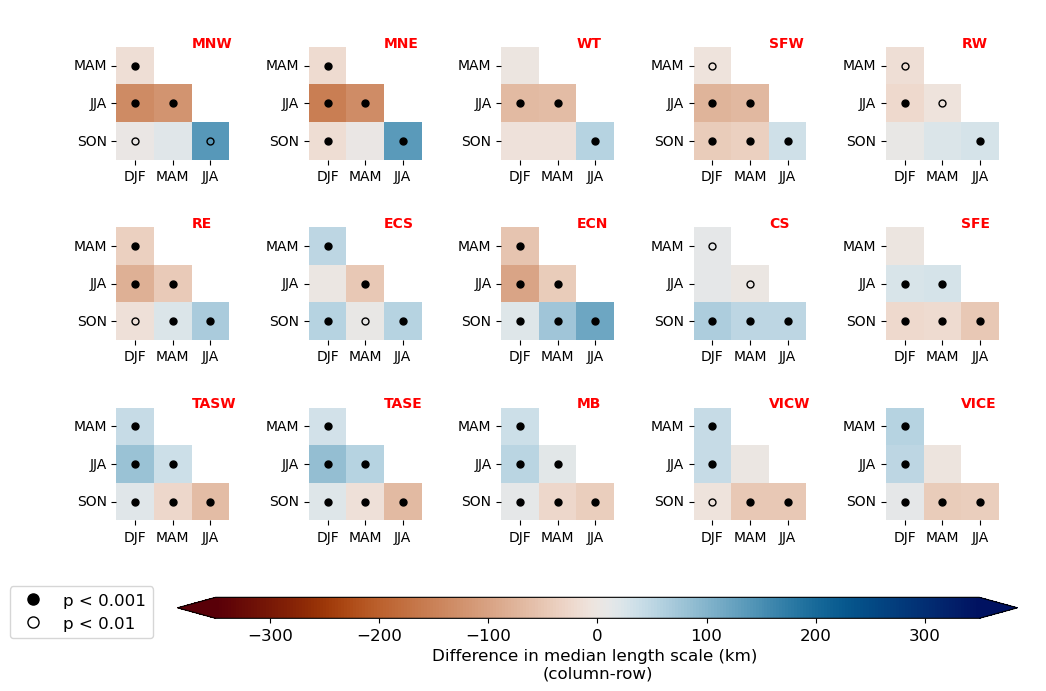

In [26]:

fig = plt.figure()
for ir, region in enumerate(region_list):
    ax=fig.add_subplot(3,5,ir+1)
    # region = "WT"
    region_self = np.array([np.nanmedian(nrm_sub_wscale_dict[region][iseason]) for iseason in range(0,4)])
    self_matrix = region_self[None, :] - region_self[:, None]
    
    # Create an upper-triangular mask if needed
    mask = np.zeros_like(self_matrix)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        # Disable the colorbar for each heatmap (cbar=False)
        g1 = sns.heatmap(self_matrix, mask=mask, square=True,
                         vmin=-350, vmax=350, cmap="cmc.vik_r", cbar=False, ax=ax)
        # Set the tick positions and labels; ensure the number matches region_list length
        n_seasons = 4-1
        ax.set_xticks(np.arange(n_seasons) + 0.5)
        ax.set_xticklabels(["DJF","MAM","JJA"], rotation=0,fontsize=10)
        ax.set_yticks(np.arange(n_seasons) + 1.5)
        ax.set_yticklabels(["MAM","JJA","SON"], rotation=0,fontsize=10)
    plt.text(2,1,region, fontweight="bold",color="r")
    # plt.title(region, fontweight="bold")
    for i in range(wilcox_dict[region].shape[0]):
        for j in range(wilcox_dict[region].shape[1]):
            p = wilcox_dict[region][i, j]
            if p < 0.001 and mask[i,j]==False:
                # Solid black dot
                markerfacecolor = "black"
                markeredgecolor = "black"
            elif p < 0.01 and mask[i,j]==False:
                # Hollow dot (no face color, just edge)
                markerfacecolor = "none"
                markeredgecolor = "black"
            else:
                continue  # Do nothing if p-value doesn't meet criteria.
            # Plot the marker at the center of cell (i, j)
            ax.plot(j + 0.5, i + 0.5, marker='o', markersize=5,
                    markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
# plt.tight_layout() 
fig.subplots_adjust(bottom = 0.15)


cbar_ax = fig.add_axes([0.18, 0.01, 0.7, 0.03]) #[left, bottom, width, height]
norm = plt.Normalize(vmin=-350, vmax=350)
sm = plt.cm.ScalarMappable(norm=norm, cmap="cmc.vik_r")
sm.set_array([])  # This is needed for the colorbar
cbar = fig.colorbar(sm,  cax = cbar_ax, orientation = "horizontal",extend ="both")#,ticks=[-1,1])
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_xlabel("Difference in median length scale (km) \n(column-row)",fontsize=12)
# Create legend elements for the p-value markers.
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markeredgecolor='black', markersize=8, label='p < 0.001'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
           markeredgecolor='black', markersize=8, label='p < 0.01')
]

# Add a common legend to the figure.
# Adjust bbox_to_anchor and loc as needed.
fig.legend(handles=legend_elements, loc='lower center', ncol=1, bbox_to_anchor=(0.10, -0.03))
 # Adjust layout so the colorbar doesn't overlap
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_wilcox.png", dpi=200, bbox_inches="tight")